In [72]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import argparse
import builtins
import math
import os
import random
import shutil
import time
import json
import warnings

import sys
sys.path.append('//Users/ivo/Desktop/thesis/pytorch-SimSiam')

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from models.simsiam import SimSiam
import torch.nn.functional as F
from setlogger import get_logger

import moco.loader
import moco.builder

import numpy as np

from collections import OrderedDict
%matplotlib inline

In [43]:
saved_path = os.path.join("logs/R50e100_bs512lr0.1/") #rs56_KDCL_MinLogit_cifar_e250 rs56_5KD_0.4w_cifar_e250
if not os.path.exists(saved_path):
    os.makedirs(saved_path)
logger = get_logger(os.path.join(saved_path, 'train.log'))

model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

In [100]:
args = {
    "resume": "../unsupervised_pretrained.pth.tar",
    "data": '/Users/ivo/Desktop/thesis/pytorch-SimSiam/data_custom'
}

# create model
model = SimSiam(backbone='resnet50')
# print(model)

# define loss function (criterion) and optimizer
# criterion = nn.CrossEntropyLoss().cuda(args.gpu)
optimizer = torch.optim.SGD(model.parameters(), 0.05,
                            momentum=0.9,
                            weight_decay=1e-4)

checkpoint = torch.load(args['resume'], map_location=torch.device('cpu'))
args['start_epoch'] = checkpoint['epoch']

state_dict_filtered = OrderedDict([(k[7:], v) if 'module.' in k else (k, v) for k, v in checkpoint['state_dict'].items()])
model.load_state_dict(state_dict_filtered)
optimizer.load_state_dict(checkpoint['optimizer'])

print("=> loaded checkpoint '{}' (epoch {})"
        .format(args['resume'], checkpoint['epoch']))

# Data loading code
traindir = os.path.join(args['data'], 'train')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(traindir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=60,  
                                          shuffle=False, drop_last=False, num_workers=4)    



=> loaded checkpoint '../unsupervised_pretrained.pth.tar' (epoch 100)


In [101]:
def cosine_similarity(p, z):
    # z = z.detach()
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return (p*z.detach()).sum(dim=1).mean()
    # return - nn.functional.cosine_similarity(p, z.detach(), dim=-1).mean()

In [102]:
z = []
p = []

In [104]:
print("Starting")

# # switch to train mode
model = model.eval()

for i, (images, _) in enumerate(train_loader):

    print(i, _)

    # # compute output
    # output, target = model(im_q=images[0], im_k=images[1])
    # loss = criterion(output, target)

    # print(output, target)
    z1, p1 = model(images)

    z += z1.detach()
    p += p1.detach()

    # # acc1/acc5 are (K+1)-way contrast classifier accuracy
    # # measure accuracy and record loss
    # # acc1, acc5 = accuracy(output, target, topk=(1, 5))
    # losses.update(loss.item(), images[0].size(0))
    # # top1.update(acc1[0], images[0].size(0))
    # # top5.update(acc5[0], images[0].size(0))

    # # compute gradient and do SGD step
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()
    
    if i > 15:
        break


Starting
0 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
1 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
2 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
3 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
4 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 

In [106]:
matrix = np.array([np.array(x) for x in p])
matrix

array([[-7.5672811e-05, -5.8723381e-06, -3.5210454e-05, ...,
        -1.4451332e-04,  2.8981251e-04, -1.9670220e-04],
       [-1.4036876e-04, -3.3351593e-05,  4.9382274e-05, ...,
        -2.0492624e-04,  2.6118476e-04, -9.7224489e-05],
       [-1.3091811e-04, -4.8289075e-06,  1.1298514e-05, ...,
        -1.7915689e-04,  2.4360075e-04, -1.4089199e-04],
       ...,
       [-8.8918605e-06,  1.4007062e-04, -5.4920692e-04, ...,
        -1.9136100e-04,  3.9594970e-04, -3.9083476e-05],
       [-8.3766761e-05,  1.7923885e-04, -2.4783832e-05, ...,
        -9.7420649e-05,  2.7169863e-04, -1.8315052e-04],
       [-1.7957581e-04,  1.9904366e-04, -6.1361061e-05, ...,
         5.7195430e-06,  2.2001378e-04, -1.7752225e-04]], dtype=float32)

In [107]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial import distance

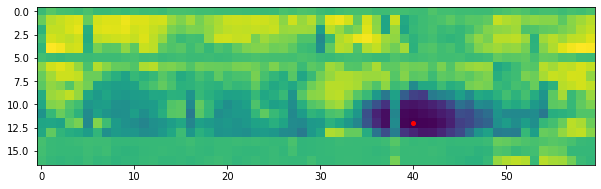

In [110]:
res = [distance.cosine(matrix[760], pix) for pix in matrix]
res = np.array(res).reshape((17, 60))

fix, ax = plt.subplots(figsize=(10,20))
ax.imshow(res)
ax.plot(40, 12, 'ro', markersize=4)